In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [11]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output,return_layer_input
from utilities_functions.ri_calculator import find_smallest_variation_to_change
from utilities_functions.explainer import generateExplanations
import torch
import pandas as pd
from tqdm import tqdm

In [4]:
attributes =['title','manufacturer','price']

In [5]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/amazongoogle_hybrid.pth')

In [6]:
testneg_classifier_inputs,testneg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'test_negatives',128,model,
                                                                        model.classifier,device=-1)

In [7]:
testpos_classifier_inputs,testpos_ids = return_layer_input('../../Structured/Amazon-Google/',
                                                                       'test_positives',128,model,
                                                                       model.classifier,device=-1)

In [11]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'negatives',128,model,
                                                                        model.classifier,device=-1)

In [12]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Amazon-Google/','positives',128,model,
                                                  model.classifier,device=-1)

In [8]:
model = model.cuda()

In [9]:
attribute_length = int((300*3)/len(attributes))
classifier_length = int(attribute_length*len(attributes))

## Test negatives analysis

In [12]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri = []
for batch in testneg_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1,
                                                                                   learning_rate=1),attributes))
        negatives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [02:08<00:00,  1.00s/it]


In [13]:
ri_norms_negative_samples = []
for ri_list in negatives_ri:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)

In [14]:
##save to file
negatives_variation_df.to_csv('experiment_results/testneg_ri_v2.csv',index=False)

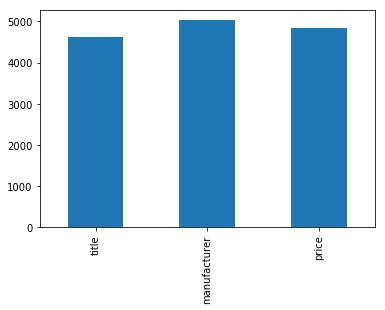

In [16]:
ri_sum_negatives = negatives_variation_df.sum(numeric_only=True)
ri_sum_negatives.plot.bar()

## Test positives analysis

In [18]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in testpos_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0
                                                                                   ,learning_rate=1),attributes))
        positives_ri.append(current_sample_ris)
        current_sample+=1

 54%|█████▍    | 69/128 [00:33<00:23,  2.52it/s]

 Gradient is null
 Gradient is null
 Gradient is null


100%|██████████| 128/128 [00:57<00:00,  2.24it/s]


In [20]:
ri_norms_positives = []
for ri_list in positives_ri:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)

In [21]:
##Save results to file
positives_variation_df.to_csv('experiment_results/testpositives_ri_v2.csv',index=False)

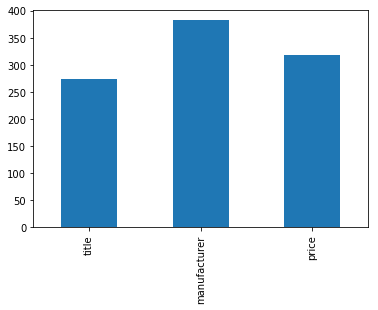

In [22]:
ri_sums = positives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

## Compute nearest neighbours

In [56]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [ ]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in negatives:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri[i][attributes.index(att)]
                                                                ,positives,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1

In [ ]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in positives:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri[i][attributes.index(att)]
                                                                ,negatives,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [ ]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c:pos_ids[c])

In [ ]:
positives_closer_vectors_df['SampleID'] = pos_ids
negatives_closer_vectors_df['SampleID'] = neg_ids

In [ ]:
positives_closer_vectors_df.to_csv('experiment_results/positives_nn.csv',index=False)
negatives_closer_vectors_df.to_csv('experiment_results/negatives_nn.csv',index=False)